In [1]:
#Importing libraries
from __future__ import division
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import os
import sys
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import cv2

c:\users\muhammed buyukkinaci\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Importing warnings to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Hyperparameters
num_iterations = 2000
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6

In [4]:
#Defining a function to initialize weights and bias
def weights(layer, layer_name, model_layers):
    wb = model_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = model_layers[0][layer][0][0][0][0]
    return W, b
#Defining conv2d layer for VGG-16
def conv2d(previous_layer, layer, layer_name, model_layers):
    W, b = weights(layer, layer_name, model_layers)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, b.size))
    return tf.nn.conv2d(previous_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
#Defining RELU + Convolution Layer together
def relu_conv2d(previous_layer, layer, layer_name, model_layers):
    return tf.nn.relu(conv2d(previous_layer, layer, layer_name, model_layers))
#Function for average Pooling 
def avg_pool(layer):
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [5]:
#Importing pretrained VGG-16
#'imagenet-vgg-verydeep-16.mat' should be in where this file exists.
def get_vgg16_model(height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    vgg = scipy.io.loadmat('./imagenet-vgg-verydeep-16.mat')
    layers = vgg['layers']
    model = {}
    model['input'] = tf.Variable(np.zeros((1, height, width, 3)), dtype = 'float32')
    model['conv1_1'] = relu_conv2d(model['input'], 0, 'conv1_1', layers)
    model['conv1_2'] = relu_conv2d(model['conv1_1'], 2, 'conv1_2', layers)
    model['avgpool1'] = avg_pool(model['conv1_2'])
    model['conv2_1'] = relu_conv2d(model['avgpool1'], 5, 'conv2_1', layers)
    model['conv2_2'] = relu_conv2d(model['conv2_1'], 7, 'conv2_2', layers)
    model['avgpool2'] = avg_pool(model['conv2_2'])
    model['conv3_1']  = relu_conv2d(model['avgpool2'], 10, 'conv3_1', layers)
    model['conv3_2']  = relu_conv2d(model['conv3_1'], 12, 'conv3_2', layers)
    model['conv3_3']  = relu_conv2d(model['conv3_2'], 14, 'conv3_3', layers)
    model['avgpool3'] = avg_pool(model['conv3_3'])
    model['conv4_1']  = relu_conv2d(model['avgpool3'], 17, 'conv4_1', layers)
    model['conv4_2']  = relu_conv2d(model['conv4_1'], 19, 'conv4_2', layers)
    model['conv4_3']  = relu_conv2d(model['conv4_2'], 21, 'conv4_3', layers)
    model['avgpool4'] = avg_pool(model['conv4_3'])
    model['conv5_1']  = relu_conv2d(model['avgpool4'], 24, 'conv5_1', layers)
    model['conv5_2']  = relu_conv2d(model['conv5_1'], 26, 'conv5_2', layers)
    model['conv5_3']  = relu_conv2d(model['conv5_2'], 28, 'conv5_3', layers)
    model['avgpool5'] = avg_pool(model['conv5_3'])
    return model

In [6]:
#Function for computing content loss 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))    
    return J_content

In [7]:
#Calculating gram matrix for a tensor
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [8]:
#Calculating style loss for a layer
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer

In [9]:
#Weights of layers in calculating style loss
STYLE_LAYERS  = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [10]:
#Computing style loss for all layers that we chose and weighted above.
def compute_style_cost(model, STYLE_LAYERS):    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [11]:
#Computing Total Cost
def total_cost(J_content, J_style, alpha = 20, beta = 30):
    J = alpha * J_content + beta * J_style
    return J

In [12]:
# Reset the graph
tf.reset_default_graph()

#Start a session
sess = tf.InteractiveSession()

In [13]:
#Reshaping and normalizing image
def reshape_and_normalize_image(image):    
    image = np.reshape(image, ((1,) + image.shape))
    image = image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    return image

In [14]:
#Reading content image & resizing
content_image = imageio.imread("content_image.jpg")
content_image = cv2.resize(content_image, (IMAGE_WIDTH,IMAGE_HEIGHT))

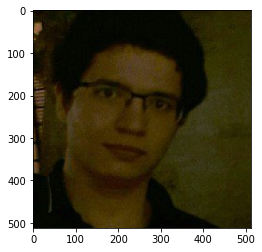

In [15]:
plt.imshow(content_image)

In [16]:
#Reshaping
content_image = reshape_and_normalize_image(content_image)

In [17]:
#Reading style image & resizing
style_image = imageio.imread("style_image.jpg")
style_image = cv2.resize(style_image, (IMAGE_WIDTH,IMAGE_HEIGHT))

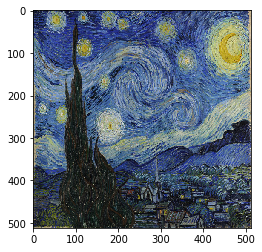

In [18]:
plt.imshow(style_image)

In [19]:
#Reshaping
style_image = reshape_and_normalize_image(style_image)

In [20]:
#Function for a noise image
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):    
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)    
    return input_image

In [21]:
#Generating a noise image
generated_image = generate_noise_image(content_image)

In [22]:
#Feeding our content image into VGG-16
model = get_vgg16_model()
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out

In [23]:
#Computing content loss between Content Image and Generated Image
J_content = compute_content_cost(a_C, a_G)

In [24]:
#Feeding our style image into VGG-16
sess.run(model['input'].assign(style_image))

#Computing style loss between Content Image and Generated Image
J_style = compute_style_cost(model, STYLE_LAYERS)

In [25]:
#Assigning weights to content and style images; alpha for content image. beta for Style Image.
J = total_cost(J_content, J_style, alpha = 20, beta = 30)

In [26]:
#Defining optimizer.
optimizer = tf.train.AdamOptimizer(2.0)

#Defining what to minimize.
train_step = optimizer.minimize(J)

In [27]:
with tf.Session() as sess:
    
    # Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    #Feeding our generated image into VGG-16
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
    
        #Running what to minimize.
        sess.run(train_step)
        
        #Computing the generated image
        generated_image = sess.run(model['input'])

        #Print every 50 iteration.
        if i % 50 == 0:
            #Computing total, content and style loss.
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            #print("Iteration " + str(i) + " :", " total cost = " + str(Jt)," content cost = " + str(Jc)," style cost = " + str(Js))
            #print()
            
            #image = np.clip(generated_image[0], 0, 255).astype('uint8')
            image = generated_image[0]
            output_file = 'temp_output_{}.jpg'.format(i)
            #Saving the picture
            imageio.imwrite(output_file, image)
    image = generated_image[0]
    #Save last generated image
    imageio.imwrite('generated_image.jpg', image)
    
    print("Finished")

Finished
